In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

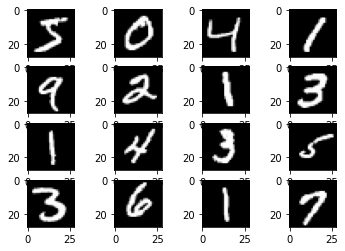

(60000, 784) (10000, 784)


In [3]:
## load the digits dataset
def load_digits(show_sample = True):
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    
    #show first 100 images
    if show_sample == True:
        nImg = 4
        for i in range(nImg*nImg):
            plt.subplot(nImg, nImg, i+1)
            plt.imshow(x_train[i], cmap = 'Greys_r')
        plt.show()
        
    x_train_1 = np.reshape(x_train, [x_train.shape[0], x_train.shape[1] * x_train.shape[2]])
    x_test_1 = np.reshape(x_test, [x_test.shape[0], x_test.shape[1] * x_test.shape[2]])
    x_train_2 = x_train_1/255
    x_test_2 = x_test_1/255
    
    return x_train_2, y_train, x_test_2, y_test

x_train, y_train, x_test, y_test = load_digits()
print(x_train.shape, x_test.shape)

In [4]:
x_train[0:600]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
## Activation functions: implement the softmax function. 
def sigm(z):
    return 1/(1 + np.exp(-z))

def dsigm(z):
    return sigm(z)*(1 - sigm(z))

def softmax(z):
    ''' softmax function for the output layer.
        The softmax function should be able to work if batch size is greater than 1.

        parameters:
            z: input numpy array. m_batch * 10
        
        return: m_batch * 10     
    '''
    
    z_temp = (z - np.max(z, axis = 1, keepdims = True))
    return np.exp(z_temp)/(np.sum(np.exp(z_temp),axis = 1, keepdims = True))
    
# test the softmax function
z = np.array([[1, 2, 3], [4, 2, 4]])
s = softmax(z)
print(s)

[[0.09003057 0.24472847 0.66524096]
 [0.46831053 0.06337894 0.46831053]]


In [ ]:
class Layer:
    
    def __init__(self, input_dim, units, activation = None): 
        '''creat a layer and initialize weights and bias. This is the constructor that 
          will be executed automatically when we create a layer instance. 
            
            parameters:
                units: the number of hidden/output nodes
                input_dim: dimensionality of the layer input
                activation: activation function
                
        '''
        self.input_dim = input_dim        
        self.units = units
        self.activation = activation

        #initialize weights and bias, and their gradients. 
        np.random.seed(0)        
        
        #std = 1/input_dim
        #self.W = 0 + std * np.random.randn(units, input_dim)
        self.W = np.random.randn(units, input_dim)
        self.bias = np.random.randn(units)
        
        #initilize gradients of weights(gW) and bias(gBias)        
        self.gW = np.zeros((units, input_dim))
        self.gBias = np.zeros((units,))        
                        
        
    def run(self, inputs):
        ''' calculate the net input and activation output of the current layer
        
            inputs: layer input. (n_sample * n_features)
          
            return:
                self.output. the activation output (units * 1)
        '''
        #calculate the net input.        
        self.net = np.matmul(inputs, self.W.T) + self.bias.T
        
        #calculate activation output. 
        #deal with both softmax and sigmoid activations
        #use self.activation to choose the activation function of the current layer
        
        if self.activation == 'sigm':           
            self.output = sigm(self.net)
            
        if self.activation == 'softmax':
            self.output = softmax(self.net)            
        
        return self.output


    
## Test code to create a layer instance/object
# create a layer with 20 hidden nodes
L1 = Layer(input_dim = 784, units = 20, activation = 'sigm')
print('L1:', L1.input_dim, L1.units, L1.activation)

# call the run function to generate the results of the first training sample
h1 = L1.run(x_train[0])
print('h1:', h1.shape)

L1: 784 20 sigm
h1: (20,)


In [ ]:

## complete the following NN class. 
class NeuralNetwork:
    
    def __init__(self):
        self.layers=[] # list of layers
        
    #  implement the 'add' function. 
    def add(self, units, input_dim, activation = 'sigm'):
        '''add one layer to neural network
        
            parameters:
                units: the number of nodes of current layer
                input_dim: input dimension (the number of nodes of the previous layer)
                activation: the activation function
        '''   
        
        L1 = Layer(input_dim = input_dim, units = units, activation = activation)
        self.layers.append(L1)
        
        
    # implement the cross-entropy loss. 
    def loss(self, y_pred, y):
        '''loss function: 1/n_samples*sum_samples(sum_output(-y_k*log(y_pred_k)))
            
            parameters:
                y_pred: predictions(n_samples * 10)
                y: target(one-hot vectors: n_samples * 10)
            return:
                loss
        '''
        
        m = y.shape[0] # the number of samples   
        loss = 1/m * (np.sum(np.sum(- y * np.log(y_pred),axis = 0)))               
        return loss
    
    # implement the forward propagation process. 
    def forward_prop(self, inputs):
        '''forward propagation calculates net input and output for all layers
            
            parameters:
                inputs: input data(n_samples * n_features)
            
            return:
                out: the output of the last layer
            
            Tip: call the run function layer by layer
        '''
        
        nLayers = len(self.layers)
        out = None
        for i in range(nLayers):
            out = self.layers[i].run(inputs) ## delete 1e-4
            inputs = out
        
        return out
    
    # implement the prediction function. 
    # using np.argmax to convert onehot vectors to categorical values
    def predict_class(self, x):
        '''predict class lables (0, 1, 2, 3, ..., 9) for data samples
        
            parameters:
                x: input(n_samples * n_features) 
            return:
                class labels
        '''    
        pred_matrix = self.forward_prop(x)
        pred_label = np.argmax(pred_matrix, axis = 1)
        return pred_label

        
    # complete the following 'train' function. 
    def train(self, inputs, targets, lr = 0.001, batch_size = 32, epochs = 50):
        '''implement the SGD process and use Back-Propagation algorithm to calculate gradients 
            
            parameters:
                inputs: training samples
                targets: training targets
                lr: learning rate
                batch_size: batch size
                epochs: max number of epochs
                
            return:
                loss_hist
        '''
        
        m = len(targets)  
        #print(m, targets.shape)
        loss_hist = np.zeros(epochs)
        
        for i in range(epochs):
            #shuffle the data
            idx = np.arange(m)
            np.random.shuffle(idx)
            inputs = inputs[idx]
            targets = targets[idx]
            
            for b in range(int(m/batch_size)):
                b_start= b*batch_size
                b_end = min((b+1)*batch_size, m)
                
                x_batch = inputs[b_start:b_end, :]
                y_batch = targets[b_start:b_end, :]
                
                
                #1) run forward propagation using the current batch to 
                # calculate net input and output for all layers
#                 for i in range(len(self.layers)):
#                     out = self.layers[i].run(x_batch) ## delete 1e-4
#                     x_batch = out
                    
                #self.forward_prop(x_batch)    

                #2) calculate the loss
                #y_pred = self.predict_class(x_batch)
                y_pred = self.forward_prop(x_batch)
                ls = self.loss(y_pred, y_batch)
                
                #3) call BP to calculate all gradients (gW and gBias)
                self.BP(x_batch, y_batch)
                
                #4) update all weights and bias
                self.updateWeights(lr)                
                ##
                
            lr = lr*0.95
            
            
            #5) record the loss of current epoch
            loss_hist = np.zeros(epochs)
            loss_hist[i] = ls
            i = i + 1
            #6) print out the loss of current epoch            
            print("Current loss is", ls)
#             print("bp1",bp1)
#             print("bp2",bp2)
        return loss_hist
    
    # implement the BP algorithm. 
    def BP(self, x, y):
        ''' Back-propagation algorithm. The implementation should be able to calculte
            gradients for a neural network with at least 3 layers.
            
            parameters:
            x: input samples (n_samples * n_features)
            y: onthot vectors (n_samples * 10)
            
        '''
        
        nLayers = len(self.layers)
        m_batch = x.shape[0]
        
        
        #1) calculate gradients for the hidden-to-output layer. 
        output = self.forward_prop(x) #from output to 2
        delta_k = (output - y)
        
        h = self.layers[1].output######
        
        self.layers[2].gW = 1/m_batch * (np.matmul(delta_k.T, h))
        #self.layers[1].gW = (np.matmul(delta_k.T, h))
        self.layers[2].bias =1/m_batch * np.sum(delta_k, axis=0)
                        
        #2) calculate gradients for the input-to-hidden layers. 
        #hi_sum_all_gwo = np.sum(self.layers[1].gW,axis = 0) 

        u_kj_2 = self.layers[2].W  #from 2 to 1 
        
        net_h_1 = self.layers[1].net
        d_net_h_1 = dsigm(net_h_1) 
        
        output_h_0 = self.layers[0].output
                           
        t1_1 = np.matmul(delta_k,u_kj_2)
        delta_j_1 = t1_1 * d_net_h_1
        
        self.layers[1].gW = 1/m_batch * (np.matmul(delta_j_1.T, output_h_0))
        self.layers[1].bias = 1/m_batch * np.sum(delta_j_1, axis=0)
        

        
        u_kj_1 = self.layers[1].W  # from 1 to 0      
        net_h_0 = self.layers[0].net
        d_net_h_0 = dsigm(net_h_0)
        
        t1_0 = np.matmul(delta_j_1,u_kj_1)
        delta_j_0 = t1_0 * d_net_h_0
        
        self.layers[0].gW = 1/m_batch * (np.matmul(delta_j_0.T, x))
        self.layers[0].bias = 1/m_batch * np.sum(delta_j_0, axis=0)
        
        #print(self.layers[0].gW)
        #return self.layers[1].gW, self.layers[0].gW
        
        #return BP_list
 
    # update all weights and bias. 
    def updateWeights(self, lr):
        '''
            parameters:
                lr: learning rate
                
        '''
        #L1gw, L0gw = nn.BP(x_train,y_target)
        nLayers = len(self.layers)
        
#         for i in range(nLayers):
#             self.layers[i].W  = self.layers[i].W + lr*self.layers[i].gW
#             self.layers[i].bias = self.layers[i].bias + lr*self.layers[i].bias


        self.layers[2].W  -= lr*self.layers[2].gW
        self.layers[2].bias -= lr*self.layers[2].bias.T        
    
    
        self.layers[1].W  -= lr*self.layers[1].gW
        self.layers[1].bias -= lr*self.layers[1].bias.T 
        
        self.layers[0].W  -= lr*self.layers[0].gW
        self.layers[0].bias -= lr*self.layers[0].bias.T
        
     

        #return self.layers[0].W , self.layers[1].W
        ##
    def Acc(self, y, y_pred):
        '''calculate accuracy
        
            parameters:
                y: target: categorical values (0, 1, ...9). n_samples * 1
                y_pred: prediction: 0,1,2, ..9. n_samples *1
                
            return: acc
        '''
        
        Acc = (sum(y_pred == y)/len(y))
        
        return Acc
            
         


In [ ]:

# Evaluation

#1) create a 3-layer NN. 
nn = NeuralNetwork()
nn.add(input_dim = 784,units = 300, activation = 'sigm')
nn.add(input_dim = 300,units = 80, activation = 'sigm')
nn.add(input_dim = 80, units = 10, activation = 'softmax')

# 2) train the NN. 
# transform y_train to onehot vectors
one_hot = OneHotEncoder()

y_train_reshape = y_train.reshape(-1,1)
y_train_onehot = one_hot.fit_transform(y_train_reshape)

y_target = y_train_onehot.toarray()

# train the network


In [18]:
# train the network
nn.train(x_train, y_target, lr = 0.0003, batch_size = 300, epochs = 50)

Current loss is 2.948754909217349
Current loss is 3.213186152765422
Current loss is 3.269706469074462
Current loss is 3.1220603765870787
Current loss is 2.946315319016159
Current loss is 3.162284277873235
Current loss is 3.151913157219362
Current loss is 3.1054960052926264
Current loss is 2.909154848041384
Current loss is 3.04785165222674
Current loss is 3.0931380612811363
Current loss is 3.00253258929433
Current loss is 3.1466948507691166
Current loss is 2.8215116614189855
Current loss is 2.975946804653701
Current loss is 3.0045019658175156
Current loss is 3.065409169176513
Current loss is 2.9032142762291513
Current loss is 2.748263021639845
Current loss is 2.9460988668028767
Current loss is 2.8000873590690287
Current loss is 2.901095684919567
Current loss is 3.1826484191178315
Current loss is 2.9827981457879464
Current loss is 2.940078682335191
Current loss is 2.98120922847225
Current loss is 2.822169516990052
Current loss is 2.922168333842473
Current loss is 2.957334105684595
Curren

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 2.79026984])

In [ ]:
# 3) calculte and print out the test and training accuracy. 

y_test_pred = nn.predict_class(x_test)
score_test = nn.Acc(y_test,y_test_pred)

y_train_pred = nn.predict_class(x_train)
score_train = nn.Acc(y_train,y_train_pred)

print("Test Score is: ",score_test)
print("Train Score is: ",score_train)
#------------------------------------------------

Test Score is:  0.24
Train Score is:  0.23995


In [ ]:
# 4) calculte and print out confusion matrix for the test set.
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_pred))

#------------------------------------------------

[[231  21  66  40 145  57 183  37  46 154]
 [ 13 562  76   9   6 222  20 160  54  13]
 [123  54 269  15  75 135 118  73  44 126]
 [100 137  19 278  48  92  84 100 126  26]
 [102  57  87 160 151  70  50  35 102 168]
 [146  71  21 181  71  51  78 105 109  59]
 [ 79  15 215  59  79  62 282 101   9  57]
 [ 21  76  71  46  78  53  88 228 181 186]
 [110  99  56  97 168  64 106  80 128  66]
 [ 68  54  87 110 134  25  63  80 168 220]]
